In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler


from cover_complex import *
from scc import *

from gudhi import SimplexTree
from gudhi import CoverComplex

import networkx as nx

# Toy Example

Let's illustrate the mapper algorithm on a simple example.

In [3]:
# Generate data points
np.random.seed(27)
t = np.linspace(0,10,300)
x_circle = np.sin(t)
y_circle = np.cos(t) + np.random.randn(len(t))/10

x_circle_2 = np.sin(t)
y_circle_2 = np.cos(t) -3 + np.random.randn(len(t))/10

x_center = np.random.randn(400)/10
y_center = np.random.randn(400)/3 - 1.5

x = np.concatenate((x_circle, x_circle_2, x_center))
y = np.concatenate((y_circle, y_circle_2, y_center))

X = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)), axis=1)


In [4]:
# Define the filter as the projection on y axis
X_filter = X[:,1]

In [5]:
# Fit mapper

mapper = MapperComplex(input_type="point cloud",
                       resolutions=np.array([7]))
mapper.fit(X, filters=X_filter)

MapperComplex(colors=array([[ 0.00000000e+00],
       [ 3.34385814e-02],
       [ 6.68397634e-02],
       [ 1.00166188e-01],
       [ 1.33380582e-01],
       [ 1.66445797e-01],
       [ 1.99324849e-01],
       [ 2.31980967e-01],
       [ 2.64377625e-01],
       [ 2.96478589e-01],
       [ 3.28247957e-01],
       [ 3.59650195e-01],
       [ 3.90650182e-01],
       [ 4.21213246e-01],
       [ 4.51305203e-01],
       [ 4.80892397e-01],
       [ 5.09941736e-01],
       [ 5.38420731e-01],
       [ 5.66297527e-01]...
       [ 4.75085109e-02],
       [ 1.05207393e-01],
       [-7.21527623e-02],
       [-2.41824374e-03],
       [ 7.25151812e-02],
       [-7.18979491e-04],
       [-4.47452026e-02],
       [-1.19525479e-01],
       [ 6.93919834e-02],
       [-3.84802992e-02],
       [-1.35111680e-01],
       [ 9.41861062e-02],
       [-8.63329050e-03],
       [-1.26048303e-01],
       [ 2.90774830e-02]]),
              filter_bnds=array([[-4.24615034,  1.25635581]]),
              gains=array([0.33333333]), resolutions=array([7]))

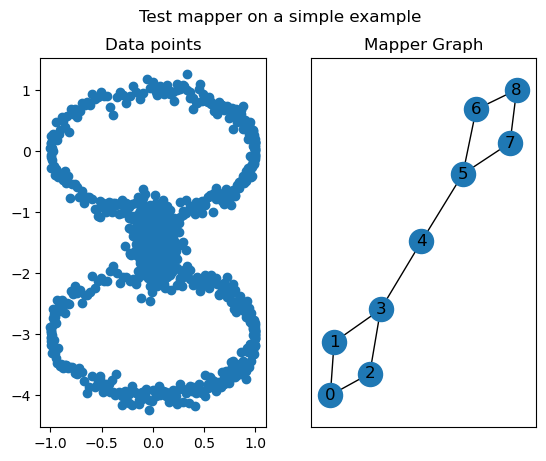

In [6]:
# Plot the resulting graph

G = mapper.get_networkx()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Test mapper on a simple example')
ax1.scatter(x, y)
ax1.set_title("Data points")
nx.draw_networkx(G, ax = ax2)
ax2.set_title("Mapper Graph")
plt.show()

# we obtain the expected graph : 2 linked circles !


# Mapper for Hi-C dataset

Let's try it on our Hi-C dataset :

In [61]:
EXP_ID = "02" # to save the computed pairwise distance matrix (it is long to compute)

# Compute pairwise distance matrix
# This class computes the SCC of 2 cells inter-chromosomically

# takes 1min to run for n_cells_sampling = 100

scc_mat = SCCMatrix(hic_matrices_folder="../data/hi-matrices/",
                    n_cells_sampling= 100, # number of cells 
                    h=20, # window size for average smoothing
                    n_slices_max=100 # maximal distance in order to take a contact into account
                    )


# Or, use the alternative class, that first computes the SCC of each 
# chromosomes separately, then computes the average of the SCC of corresponding chromosomes:

#scc_mat = SCCMatrix_chromwise("data/chromosomes.txt",
#                    "data/hi-matrices/",
#                    500, # number of cells 
#                    h=10, # window size for average smoothing
#                    n_slices_max=50 # maximal distance in order to take a contact into account
#                    )

X = scc_mat.compute_pairwise_dist()
#np.save("output/pairwise_distance_" + EXP_ID +".npy", X)


100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


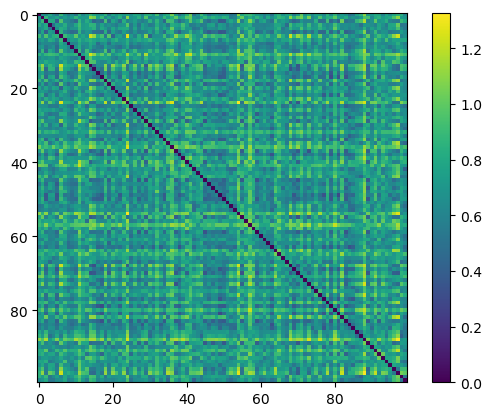

In [62]:
# plot the pairwise distance matrix
plt.imshow(X)
plt.colorbar()
plt.show()

In [63]:
# Get cell features to colorize the graph ; here we use mean_insu, but we have to test with "f near band", "repli score" and "f mitotic band"
cell_features = pd.read_table("../data/features.txt")
cell_features.index = cell_features["cell_nm"] # set cell names as index
mean_insu = cell_features["mean_insu"]

# cells that where selected :
cells_id = scc_mat.contact_maps_files # retrieve the name of the cells that were used to compute the pairwise distances
for i, cell in enumerate(cells_id): # correct the names (replace "." by "_")
    cells_id[i] = cell.replace(".","_")

mean_insu_cells = mean_insu.loc[cells_id]

# save the cells that were drawn for this experiment
# np.save("output/cells_di_" + EXP_ID + ".npy", cells_id)


In [64]:
# compute PCA of this distance matrix ; it will out filter (= lens)
X_scaled = StandardScaler().fit_transform(X)
transformer = KernelPCA(n_components=2, kernel='linear') # we could try other kernels
pca = transformer.fit_transform(X_scaled)

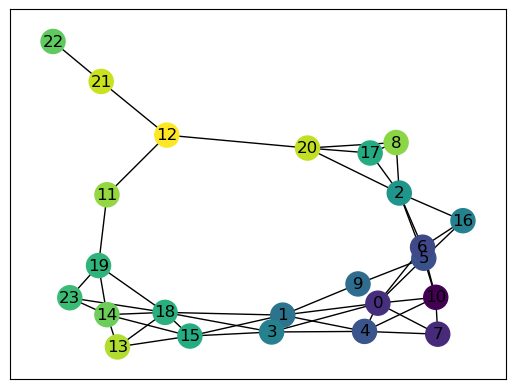

In [109]:
# compute mapper, using 2 first Principal Components as filter
    
RES = 5
GAIN = 0.3

mapper = MapperComplex(input_type="distance matrix", 
                        colors=mean_insu_cells,
                        resolutions=np.array([RES, RES]), gains=np.array([GAIN, GAIN]),
                        clustering=AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=2.5, affinity="euclidean"))
mapper = mapper.fit(X, filters=pca) # filters : numpy array of shape (num_points) x (num_filters) Each column of the numpy array defines a scalar function defined on the input points.

# plot graph
G = mapper.get_networkx()
plt.figure()
nx.draw_networkx(G,
                node_color=[mapper.node_info_[v]["colors"] for v in G.nodes()])
plt.show()

On voit bien une boucle, et la valeur de la feature mean_insu est bien corrélée avec la progression du cycle !

# TO DO next

On a trouvé un set de paramètre qui permet de mettre en évidence le cycle cellulaire ! (cf exemple ci-dessus)

Suite : Etude des hyperparamètres (pas forcément tous !) :
 
SCC :    
- `h`, la taille de la fenêtre pour l'average smoothing
- `n_slices_max` : la distance max entre 2 DNA bins pour prendre en compte le contact. A voir si on peut calculer le SCC en ne mettant pas ce seuil, mais je crois que ça sera super long.
- Est-ce qu'on le calcule chromosome par chromosome (`SCCMatrix_chromwise()`), ou est-ce qu'on utilise l'ensemble de la contact map avec tous les crhomosomes d'un coup (`SCCMatrix()`) ?

Mapper : 
- Le type de Kernel dans la PCA
- Le nombre de PCs qu'on prend en compte comme filter
- `RES` : le paramètre de résolution
- `GAIN` : le paramètre d'overlap
- L'algo de clustering utilisé, et notamment le seuil $\delta$